# Stroke are one of the leading causes of death and disability in the United States. 
Every year nearly 800,000 Americans suffer from stroke [[1](https://www.cdc.gov/stroke/facts.htm#:~:text=Every%2040%20seconds%2C%20someone%20in,minutes%2C%20someone%20dies%20of%20stroke.&text=Every%20year%2C%20more%20than%20795%2C000,United%20States%20have%20a%20stroke.)]. 
Of these cases, nearly 140,000 
Americans die and another 75% of victims are left with some form of dysfunction 
or disability [[2](https://www.frontiersin.org/articles/10.3389/fneur.2021.649088/full)].  
However, 80% of all strokes are preventable with treatment and 
life style changes if detected early [[1](https://www.cdc.gov/stroke/facts.htm#:~:text=Every%2040%20seconds%2C%20someone%20in,minutes%2C%20someone%20dies%20of%20stroke.&text=Every%20year%2C%20more%20than%20795%2C000,United%20States%20have%20a%20stroke.)].
Stroke detection has become increasingly 
important in trying to find factors that predict a stroke before it even happens. 
By performing data exploration, feature engineering, and machine learning modeling
on a dataset containing many records of 11 key features the could predict stroke
events, we hope to produce a machine learning model for predicting stroke events
early to help curtail preventable deaths and ailments caused by stroke.

## Libraries and Background Data 
Lets go ahead and import our libraries and read in the data set. The data itself was aquired from a confidential source on Kaggle found [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [5]:
# read in data
raw_data = pd.read_csv("healthcare-dataset-stroke-data.csv")
# we chose to remove the id's from the data since they don't add
# anything meaningful and increase the dimensionality of the data 
raw_data = raw_data.drop("id", axis=1)
raw_data.shape

(5110, 11)

# Data Cleaning and Preparation
Here we can see the first 10 records in our raw dataset prior to any data cleaning or feature engineering. 

In [7]:
raw_data.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


## Ambiguous and Missing Values
Before we are able to model stroke, we have to clean our data first. It appears that we have two columns with NaNs and Unknowns: `bmi` and `smoking_status`.
We must handle these values by either removing them or imputing them. Let's first explore the `smoking_status` column.

There are 1544 records who have an "Unknown" smoking status.



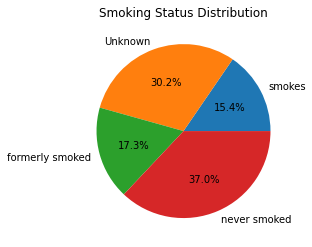

In [8]:
def get_count(df, col, val) :
  return df[df[col] == val].shape[0]

# First lets print the distribution of the different smoking status in the data
smk_lables = ['smokes', 'Unknown', 'formerly smoked', 'never smoked']
smk_cnt = []
for label in smk_lables :
  smk_cnt.append(get_count(raw_data, "smoking_status", label))

print("There are", smk_cnt[1], "records who have an \"Unknown\" smoking status.\n")

plt.title("Smoking Status Distribution")
plt.pie(smk_cnt, labels = smk_lables, autopct='%1.1f%%')
plt.show()

## Decision behind dropping unkown smoking status
We decided to drop records with `Unknown` smoking status since its hard to quantify what that means. Since we wanted to determine if a clear relationship between smoking status and the chances of having a stroke existed, we only wanted to examine records where that relationship is clear. Since we still remain over the 1,000 record limit and still have records that represent both stroke and non stroke patients, we made the decision to drop the records with an `Unknown` smoking status.

In [9]:
dropped_data = raw_data[raw_data.smoking_status != "Unknown"]
print("After removing the records with \"Unkown\" as their smoking status, we are left with", dropped_data.shape[0], "records.")

After removing the records with "Unkown" as their smoking status, we are left with 3566 records.


# Quantifiying smoking status
We decided to make smoking status numerical described in the comment below. 

In [10]:
# smokes -> 2, formerly smoked -> 1, never smoked -> 0
dropped_data['smoking_status'] = dropped_data['smoking_status'].replace(["smokes"], "2")
dropped_data['smoking_status'] = dropped_data['smoking_status'].replace(["never smoked"], "0")
dropped_data['smoking_status'] = dropped_data['smoking_status'].replace(["formerly smoked"], "1")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

## Examining BMI Values
Lets figure out how the NaN values in BMI affect the data.

In [11]:

num_bmi_nan = dropped_data["bmi"].isnull().sum()
total_entries = len(dropped_data.index)
num_bmi_nan / total_entries * 100

3.9259674705552436

Only 3.9% of the data contains a NaN in the data. Since there aren't that many, it seems
reasonable to impute the BMI with the other values.
However, before we do so, this may introduce some bias toward stroke or non-stroke patients.
How many of the missing values are classified as stroke patients compared to non-stroke patients?

In [12]:
raw_stroke_bmi_data = dropped_data[dropped_data["stroke"] == 1]["bmi"]
raw_nonstroke_bmi_data = dropped_data[dropped_data["stroke"] == 0]["bmi"]

num_stroke_bmi_nan = raw_stroke_bmi_data.isnull().sum()
num_nonstroke_bmi_nan = raw_nonstroke_bmi_data.isnull().sum()

total_stroke_entries = len(raw_stroke_bmi_data.index)
total_nonstroke_entries = len(raw_nonstroke_bmi_data.index)

print("# of NaN BMI values in stroke:", num_stroke_bmi_nan)
print("# of Stroke Patients:", total_stroke_entries)
print("Percentage of NaN BMI in Stroke Patients:", num_stroke_bmi_nan / total_stroke_entries * 100, "\n")
print("# of NaN BMI values in nonstroke:", num_nonstroke_bmi_nan)
print("# of Nonstroke Patients:", total_nonstroke_entries)
print("Percentage of NaN BMI in Nonstroke Patients:", num_nonstroke_bmi_nan / total_nonstroke_entries * 100, "\n")

# of NaN BMI values in stroke: 22
# of Stroke Patients: 202
Percentage of NaN BMI in Stroke Patients: 10.891089108910892 

# of NaN BMI values in nonstroke: 118
# of Nonstroke Patients: 3364
Percentage of NaN BMI in Nonstroke Patients: 3.507728894173603 



It appears that there are more missing BMI values for stroke patents than non-stroke patients, 
proportionally. Since these proportions are different, we will impute the BMI for stroke and non-stroke patients separately. By what metric should we impute the BMI? If the BMI has a significant skew, the metric by which we impute this data may impact our results.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f39dfb8e9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f39dfb16490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f39dfb8e4d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f39dfb16f50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f39dfb1f4d0>],
 'means': []}

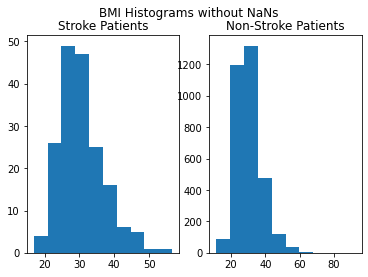

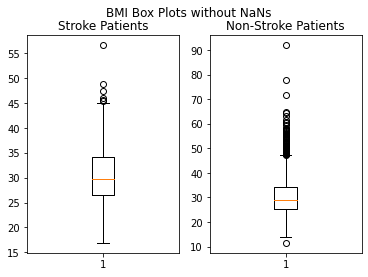

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("BMI Histograms without NaNs")

ax1.set_title("Stroke Patients") # TODO horizontal axes label
ax1.hist(raw_stroke_bmi_data[~np.isnan(raw_stroke_bmi_data)])

ax2.set_title("Non-Stroke Patients")
ax2.hist(raw_nonstroke_bmi_data[~np.isnan(raw_nonstroke_bmi_data)])

# %%
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("BMI Box Plots without NaNs")

ax1.set_title("Stroke Patients")
ax1.boxplot(raw_stroke_bmi_data[~np.isnan(raw_stroke_bmi_data)])

ax2.set_title("Non-Stroke Patients")
ax2.boxplot(raw_nonstroke_bmi_data[~np.isnan(raw_nonstroke_bmi_data)])

The histograms and boxplots shows that the data seems to be partially right-skewed.
Using the mean for imputation may lead to less-than-ideal results. Thus, we shall use
the median to impute the missing BMI values.

In [14]:
stroke_median = raw_stroke_bmi_data.median()
nonstroke_median = raw_nonstroke_bmi_data.median()
print("BMI Median for Stroke Patients: ", stroke_median)
print("BMI Median for Nonstroke Patients: ", nonstroke_median)

imputed_stroke_data = dropped_data[dropped_data["stroke"] == 1].fillna(stroke_median)
imputed_nonstroke_data = dropped_data[dropped_data["stroke"] == 0].fillna(nonstroke_median)
data = pd.concat([imputed_stroke_data, imputed_nonstroke_data])
data.head(10)

BMI Median for Stroke Patients:  29.75
BMI Median for Nonstroke Patients:  29.0


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,1,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.75,0,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,0,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,2,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,0,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.00,1,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.40,0,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.80,0,1
10,Female,81.0,1,0,Yes,Private,Rural,80.43,29.70,0,1
11,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.80,2,1


# Feature Engineering
Next we begin feature engineering our already existant 
features inorder to extract more useful features to 
build our model on.

## Average Glucose Level to Age Ratio
Studies indicate that the average glucose level in people can vary depending on age. 
This means it can be useful to calculate a "avg glucose to age" ratio based on binned values. 
Studies indicate that average glucose values tend to differ in different age groups such as from 0-6, 6-12, 13-19, 20-65, and 65+.
By calculating the average glucose level of each of these groups then calculating the ratio 
relative to this average we can generate a ratio that better represents the "unusualness" of the 
average glucose in a particular record.



In [24]:
group_one = 0
count_one = 0
group_two = 0
count_two = 0
group_three = 0
count_three = 0
group_four = 0
count_four = 0
group_five = 0
count_five = 0

for age in data["age"]:
   if age <= 5:
      group_one += age
      count_one += 1
   elif age <= 12:
      group_two += age
      count_two += 1
   elif age <= 19:
      group_three += age
      count_three += 1
   elif age <= 65:
      group_four += age
      count_four += 1
   else:
      group_five += age
      count_five += 1
    
group_one_avg = group_one / count_one if count_one != 0 else 0
group_two_avg = group_two / count_two if count_two != 0 else 0
group_three_avg = group_three / count_three if count_three != 0 else 0
group_four_avg = group_four / count_four if count_four != 0 else 0
group_five_avg = group_five / count_five if count_five != 0 else 0

glucose_age_ratio = []

for age in data["age"]:
   if age <= 5:
      glucose_age_ratio.append(age/group_one_avg)
   elif age <= 12:
      glucose_age_ratio.append(age/group_two_avg)
   elif age <= 19:
      glucose_age_ratio.append(age/group_three_avg)
   elif age <= 65:
      glucose_age_ratio.append(age/group_four_avg)
   else:
      glucose_age_ratio.append(age/group_five_avg)

data["glucose_age_ratio"] = glucose_age_ratio

Here we can see that a new column glucose_age_ratio was added. This column now represents the 
ratio of the record's average glucose relative to their age grouping's mean. There is also the descriptive 
statistics of this new feature displayed.

In [28]:
print(data["glucose_age_ratio"].describe())
data.head(10)

count    3566.000000
mean        1.000000
std         0.248308
min         0.453913
25%         0.862435
50%         1.021305
75%         1.167194
max         1.475218
Name: glucose_age_ratio, dtype: float64


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,glucose_age_ratio
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,1,1,0.900368
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.75,0,1,1.384436
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,0,1,1.075066
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,2,1,1.112088
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,0,1,1.061628
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.00,1,1,1.088505
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.40,0,1,0.994436
7,Female,69.0,0,0,No,Private,Urban,94.39,22.80,0,1,0.927245
10,Female,81.0,1,0,Yes,Private,Rural,80.43,29.70,0,1,1.088505
11,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.80,2,1,1.384436


## Diabetes Evidence
Studies indicate that having diabetes increases your risk of a stroke by 
1.5 times. Although diabetes was not a recorded feature in the dataset, using 
the average glucose level we can feature engineer to create a binary "diabetes_evidence" 
feature that reports if there is evidence of diabetes based on glucose level. Blood sugar tests 
determine that a person has diabetes if they have an average gluvose level above 154. We can use this 
threshold and determine diabetes evidence for each record based on this test.


In [30]:
diabetes_evidence = []
for avg_glucose_level in data["avg_glucose_level"]:
   if avg_glucose_level >= 154:
      diabetes_evidence.append(1)
   else:
      diabetes_evidence.append(0)

data["diabetes_evidence"] = diabetes_evidence

Here we can see that a new column diabetes_evidence was added. This column now represents the 
There is also the descriptive statistics of this new feature displayed.

In [31]:
print(data["diabetes_evidence"].describe())
data.head(10)

count    3566.000000
mean        0.162928
std         0.369351
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: diabetes_evidence, dtype: float64


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,glucose_age_ratio,diabetes_evidence
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,1,1,0.900368,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.75,0,1,1.384436,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,0,1,1.075066,0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,2,1,1.112088,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,0,1,1.061628,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.00,1,1,1.088505,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.40,0,1,0.994436,0
7,Female,69.0,0,0,No,Private,Urban,94.39,22.80,0,1,0.927245,0
10,Female,81.0,1,0,Yes,Private,Rural,80.43,29.70,0,1,1.088505,0
11,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.80,2,1,1.384436,0


## Average Glucose Level to BMI Ratio
The average glucose level can also vary according to 
BMI. Inorder to better measure a person's glucose level 
in respect to their BMI, we can make a ratio that divides 
a person's avg glucose level by their BMI. 

In [32]:
glucose_bmi_ratio = []

for index, row in data.iterrows():
   glucose_bmi_ratio.append(row["avg_glucose_level"]/row["bmi"])

data["glucose_bmi_ratio"] = glucose_bmi_ratio

Here we can see that a new column glucose_bmi_ratio was added. This column now represents the 
ratio of the record's average glucose relative to their bmi. There is also the descriptive 
statistics of this new feature displayed.

In [33]:
print(data["glucose_bmi_ratio"].describe())
data.head(10)

count    3566.000000
mean        3.733199
std         1.695130
min         0.618478
25%         2.554261
50%         3.259659
75%         4.418947
max        15.467516
Name: glucose_bmi_ratio, dtype: float64


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,glucose_age_ratio,diabetes_evidence,glucose_bmi_ratio
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,1,1,0.900368,1,6.248361
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.75,0,1,1.384436,1,6.796975
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,0,1,1.075066,0,3.259077
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,2,1,1.112088,1,4.977616
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,0,1,1.061628,1,7.255000
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.00,1,1,1.088505,1,6.421034
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.40,0,1,0.994436,0,2.558029
7,Female,69.0,0,0,No,Private,Urban,94.39,22.80,0,1,0.927245,0,4.139912
10,Female,81.0,1,0,Yes,Private,Rural,80.43,29.70,0,1,1.088505,0,2.708081
11,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.80,2,1,1.384436,0,3.273370


# Modeling
First, lets go ahead and separate our labels and features. 

In [45]:
data_features = data.drop(columns=['stroke'])
labels = data['stroke']

data_features = pd.get_dummies(data_features, columns=["ever_married", "Residence_type", "gender", "work_type"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.20)

data_features.head(10)

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,glucose_age_ratio,diabetes_evidence,glucose_bmi_ratio,ever_married_Yes,Residence_type_Urban,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,67.0,0,1,228.69,36.60,1,0.900368,1,6.248361,1,1,1,0,0,1,0,0
1,61.0,0,0,202.21,29.75,0,1.384436,1,6.796975,1,0,0,0,0,0,1,0
2,80.0,0,1,105.92,32.50,0,1.075066,0,3.259077,1,0,1,0,0,1,0,0
3,49.0,0,0,171.23,34.40,2,1.112088,1,4.977616,1,1,0,0,0,1,0,0
4,79.0,1,0,174.12,24.00,0,1.061628,1,7.255000,1,0,0,0,0,0,1,0
5,81.0,0,0,186.21,29.00,1,1.088505,1,6.421034,1,1,1,0,0,1,0,0
6,74.0,1,1,70.09,27.40,0,0.994436,0,2.558029,1,0,1,0,0,1,0,0
7,69.0,0,0,94.39,22.80,0,0.927245,0,4.139912,0,1,0,0,0,1,0,0
10,81.0,1,0,80.43,29.70,0,1.088505,0,2.708081,1,0,0,0,0,1,0,0
11,61.0,0,1,120.46,36.80,2,1.384436,0,3.273370,1,0,0,0,0,0,0,0


## Bayes

In [55]:
clf = GaussianNB()
clf.fit(X_train, y_train)
bayes_acc = cross_val_score(clf, data_features, labels, cv=10)

sum = 0
for accuracy in bayes_acc : 
  sum += accuracy

result = sum / len(bayes_acc)

print("Accuracy", result * 100)

Accuracy 30.256979196172846


In [48]:
pred = cross_val_predict(clf, data_features, labels, cv = 10)
cm = confusion_matrix(labels, pred)
print(cm)

report = classification_report(labels, pred)
print(report)

[[ 878 2486]
 [   1  201]]
              precision    recall  f1-score   support

           0       1.00      0.26      0.41      3364
           1       0.07      1.00      0.14       202

    accuracy                           0.30      3566
   macro avg       0.54      0.63      0.28      3566
weighted avg       0.95      0.30      0.40      3566



## KNN
This one takes a really long time (~4 mins)

Recorded Results:
Accuracy: 94.2233185408995

Best Params {'knn__n_neighbors': 8, 'pca__n_components': 7}


final accuracy: 94.27934988862304

In [53]:
scaler = StandardScaler()
pca = PCA()
kneighbors = KNeighborsClassifier(n_neighbors=7)
pipeline = Pipeline(steps = [("scaler", scaler), ("pca", pca), ("knn", kneighbors)])
cross_val_acc = cross_val_score(estimator=pipeline, X=data_features, y=labels, cv=10)

print("Accuracy:", cross_val_acc.mean() * 100)

# KNN Hypertuning 
param_grid = {
    'pca__n_components': list(range(5, 17)),
    'knn__n_neighbors': list(range(1, 15))
}

clf = GridSearchCV(pipeline, param_grid, cv=5)
grid_res = clf.fit(data_features, labels)
print("Best Params", grid_res.best_params_) 
print("Accuracy: ", grid_res.best_score_ * 100)

score = cross_val_score(clf, data_features, labels, cv=5)
print("final accuracy", score.mean() * 100)

Accuracy: 94.2233185408995
Best Params {'knn__n_neighbors': 8, 'pca__n_components': 7}
Accuracy:  0.9433541158398843
final accuracy 0.9427934988862304


## SVM
This one takes like 8 mins or something. 
Results:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3364
           1       0.00      0.00      0.00       202

    accuracy                           0.94      3566
   macro avg       0.47      0.50      0.49      3566
weighted avg       0.89      0.94      0.92      3566

In [57]:
scaler = StandardScaler()
pca = PCA()
svc = SVC()


pipeline = Pipeline(steps = [("scaler", scaler), ("pca", pca), ("svc", svc)])

param_grid = {
    'pca__n_components': list(range(5, 17)),
    'svc__kernel': ["linear", "rbf", "poly"]
}

clf = GridSearchCV(pipeline, param_grid, cv=5)
pred = cross_val_predict(clf, data_features, labels, cv=5)
report = classification_report(labels, pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3364
           1       0.00      0.00      0.00       202

    accuracy                           0.94      3566
   macro avg       0.47      0.50      0.49      3566
weighted avg       0.89      0.94      0.92      3566



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Network


In [ ]:
scaler = StandardScaler()
nn = MLPClassifier()

pipeline = Pipeline(steps = [("scaler", scaler), ("nn", nn)])

param_grid = {
    'nn__hidden_layer_sizes' : [(30,), (40,), (50,), (60,)],
    'nn__activation' : ['logistic', 'tanh', 'relu']
}

clf = GridSearchCV(pipeline, param_grid, cv=5)
score = cross_val_score(clf, data_features, labels, cv=5)
print("accuracy", score.mean())